### Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

### Load and process data

In [4]:
#read from the training data.npy file

trainingData = np.load('../homework2_TimeSeriesForecasting/homework2_data/training_data.npy')
'''
'training_data.npy': it contains a numpy array of shape (48000, 2776). 48000 time series of length 2776.
'''

categories = np.load('../homework2_TimeSeriesForecasting/homework2_data/categories.npy')
'''
'categories.npy': it contains a numpy array of shape (48000,), containing for each of the time series the code of its category. 
The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.
'''


validPeriods = np.load('../homework2_TimeSeriesForecasting/homework2_data/valid_periods.npy')
'''
'valid_periods.npy': it contains a numpy array of type (48000, 2) containing 
for each of the time series the start and end index of the current series, i.e. the part without padding.
'''


"\n'valid_periods.npy': it contains a numpy array of type (48000, 2) containing \nfor each of the time series the start and end index of the current series, i.e. the part without padding.\n"

In [5]:
print(trainingData.shape)
print(trainingData[0])

print(categories.shape)
print(categories[0])

print(validPeriods.shape)
print(validPeriods[0])

(48000, 2776)
[0.         0.         0.         ... 0.60277778 0.36759259 0.33148148]
(48000,)
D
(48000, 2)
[2325 2776]


In [6]:
# Inspect activities timestamps
def plot_amount_of_categories(categories, title='Occurrences of each category'):    
    plt.figure(figsize=(17,5))
    sns.countplot(x = categories, order = np.unique(categories))
    plt.title(title)
    plt.show()

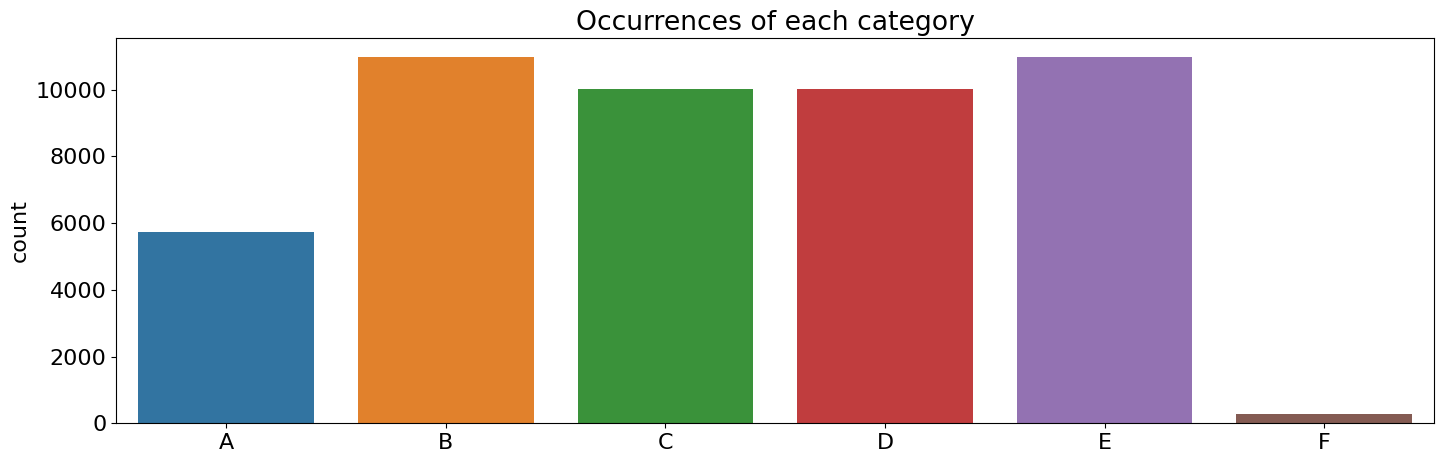

In [7]:
plot_amount_of_categories(categories)

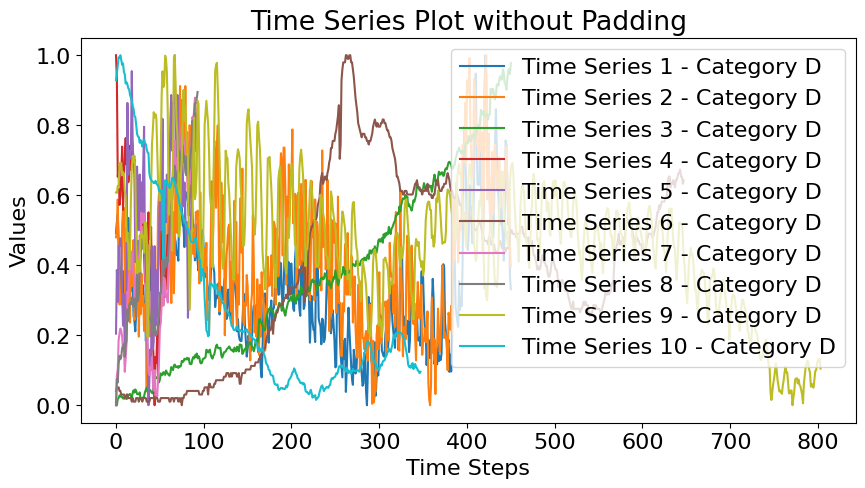

In [8]:
plt.figure(figsize=(10, 5))
for i in range(10):  # You can adjust the number of time series to plot
    start_index, end_index = validPeriods[i]
    category = categories[i]
    plt.plot(trainingData[i, start_index:end_index], label=f'Time Series {i + 1} - Category {category}')

plt.title('Time Series Plot without Padding')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

In [9]:
def plot_first_time_series_of_category(category, data, valid_periods):
    # Find the indices of the first instance of the given category
    indices = np.where(categories == category)[0]

    if len(indices) == 0:
        print(f"No instances found for category: {category}")
        return

    # Select the first index for the given category
    index = indices[0]

    # Get the start and end indices for the valid part of the time series
    start_index, end_index = valid_periods[index]

    # Plot the time series without padding
    plt.figure(figsize=(10, 5))
    plt.plot(data[index, start_index:end_index])
    plt.title(f'Time Series - Category: {category}')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.show()


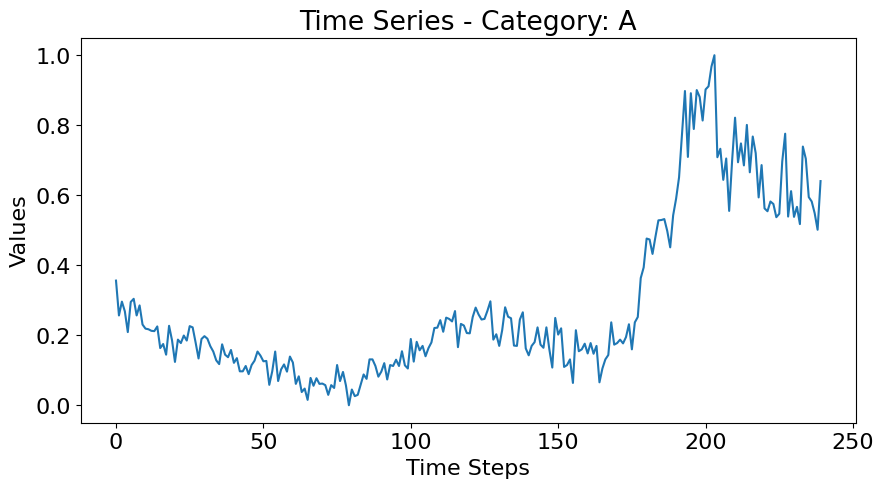

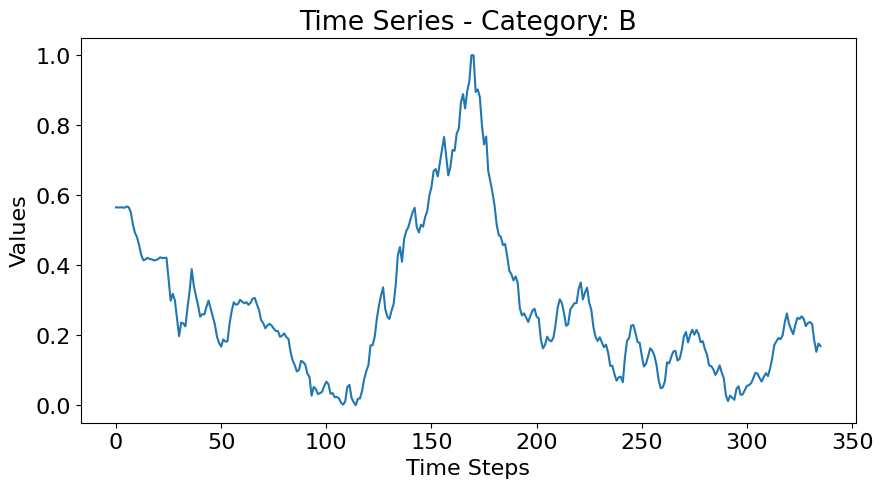

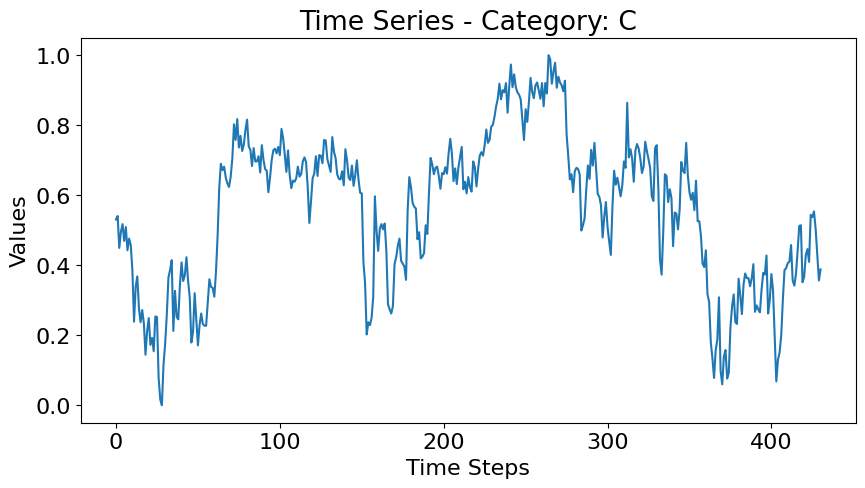

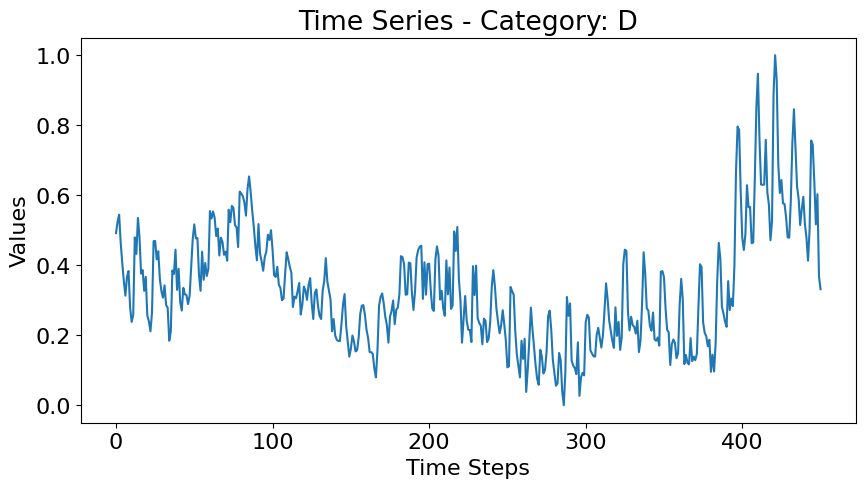

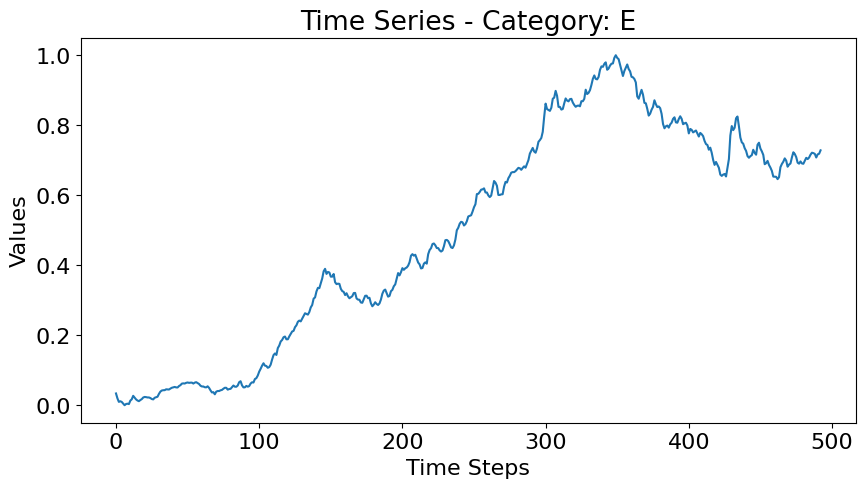

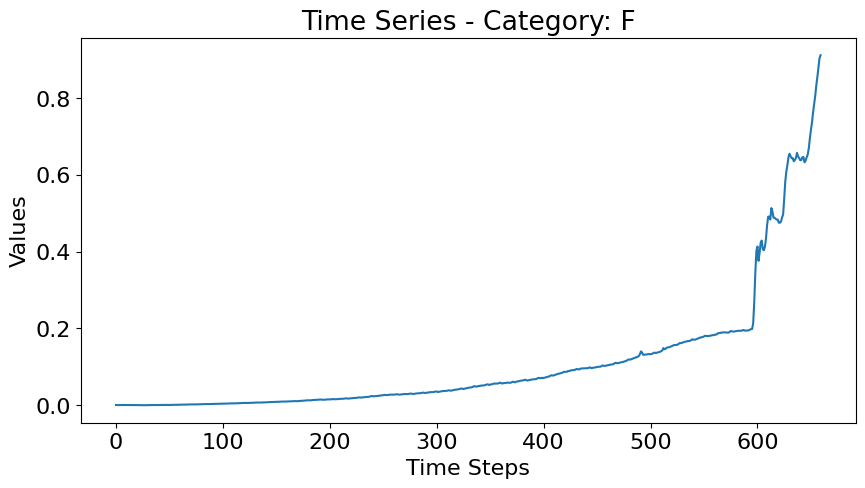

In [10]:
for category in np.unique(categories):
    plot_first_time_series_of_category(category, trainingData, valid_periods=validPeriods)

Preprocessing

In [11]:
def plot_number_of_data_points_per_time_series(data, valid_periods, category=None):
    # Get the start and end indices for the valid part of the time series
    plt.figure(figsize=(10, 5))
    yLim = 0
    for i in range(len(data)):
        if category is not None and categories[i] != category:
            continue
        
        start_index, end_index = valid_periods[i]
    
        # Calculate the number of data points within the valid period
        num_data_points = end_index - start_index

        # Plot a bar graph for the number of data points within the valid period
        yLim = max(yLim, num_data_points)
        plt.bar([i], [num_data_points])
    plt.title(f'Number of Data Points per Time Series - Category: {category if category is not None else "All"}')
    plt.xlabel('Time Series')
    plt.ylabel('Number of Data Points')
    plt.ylim([0, yLim])
    plt.show()

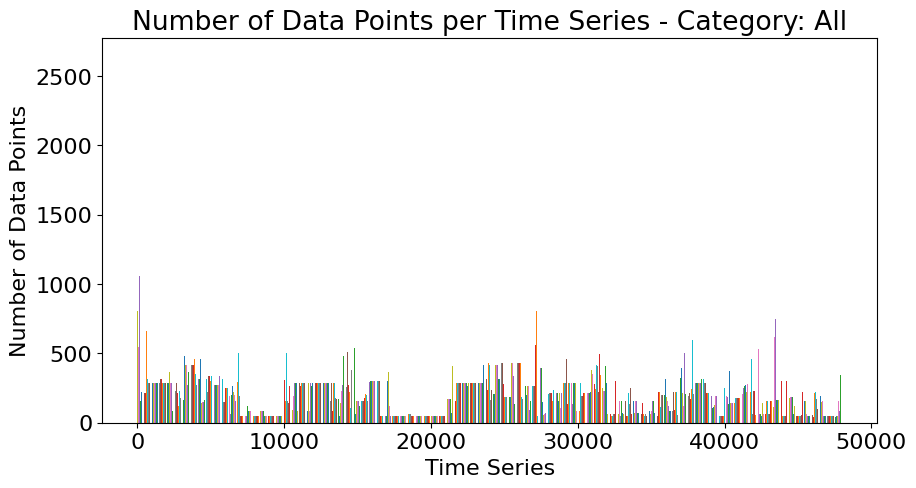

In [12]:
plot_number_of_data_points_per_time_series(trainingData, validPeriods)

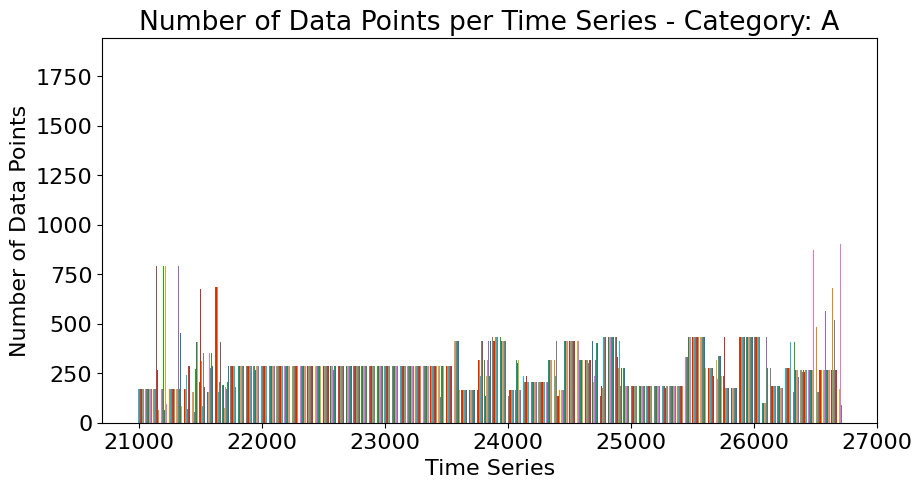

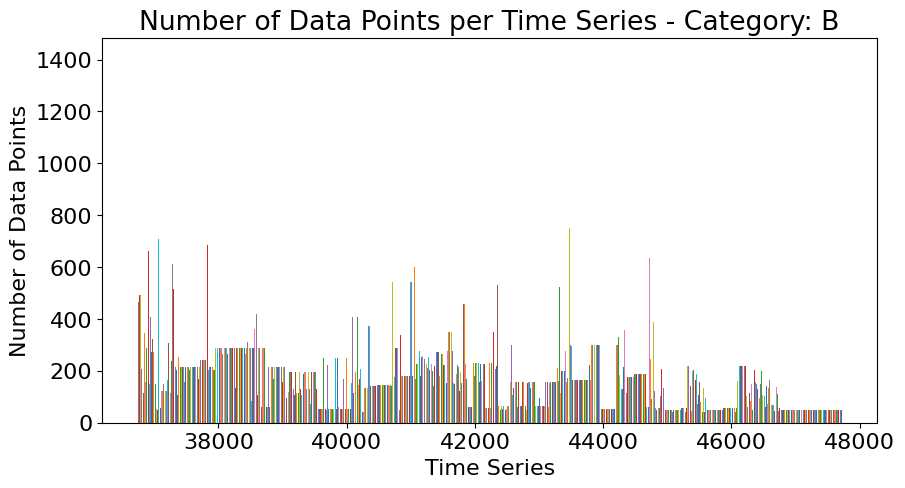

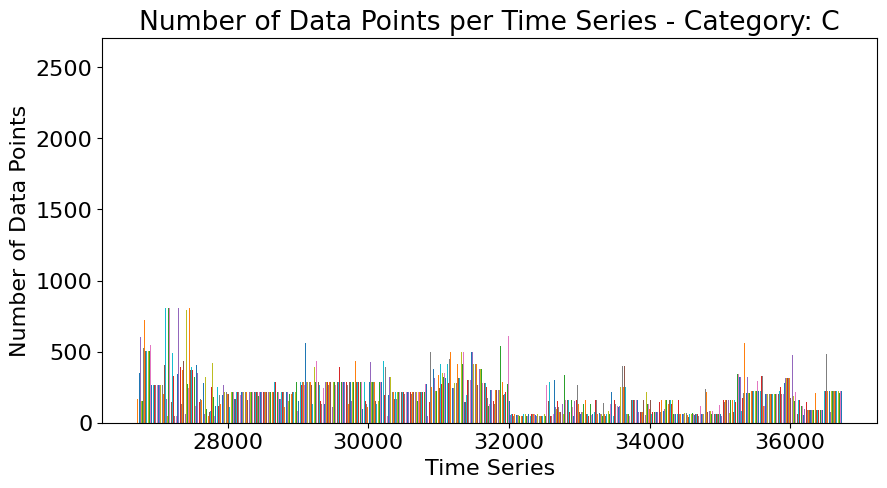

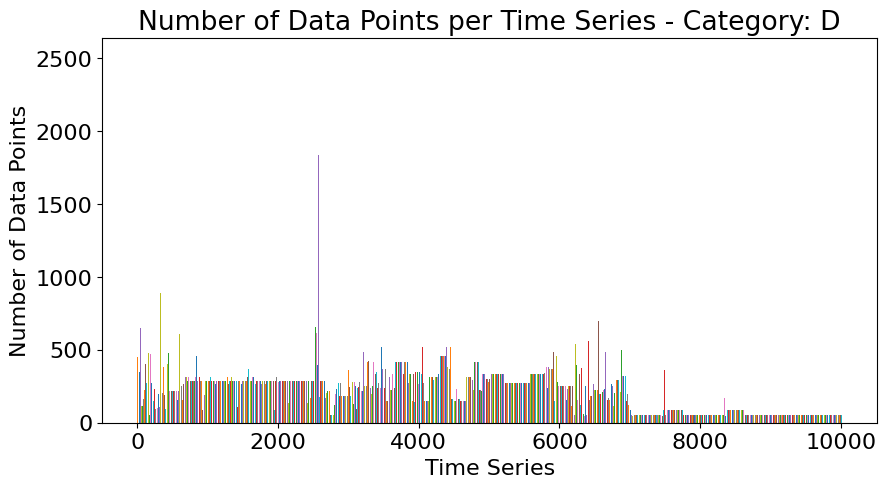

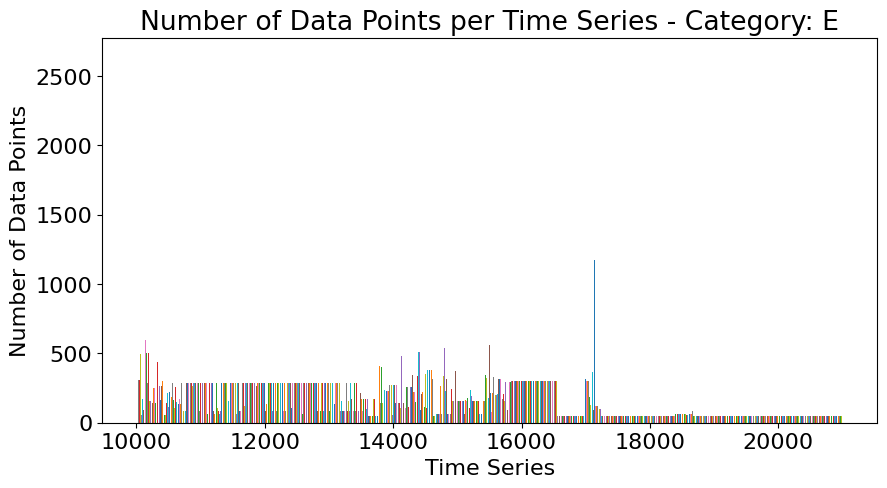

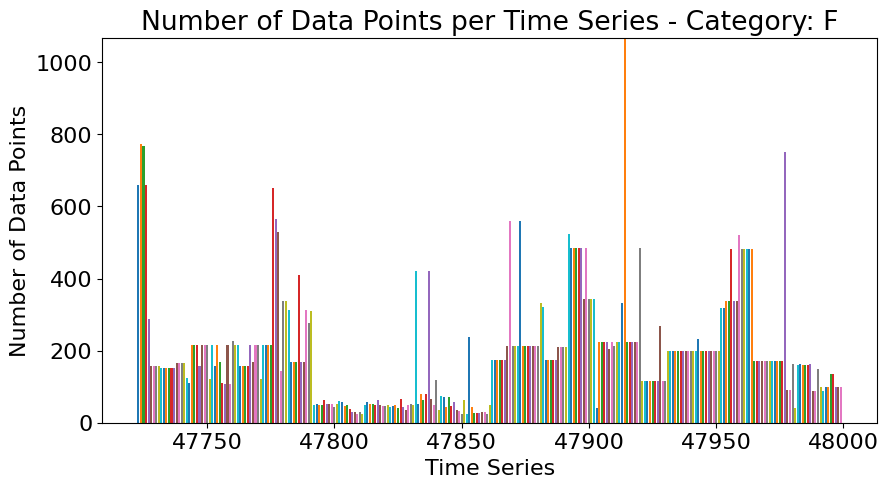

In [13]:
for category in np.unique(categories):
    plot_number_of_data_points_per_time_series(trainingData, validPeriods, category=category)

Split, Encode and Normalize

In [14]:
# Split over time series
def split_over_time_series(data, valid_periods, categories, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True, seed=42):
    # Check that the ratios add up to 1
    assert train_ratio + val_ratio + test_ratio == 1

    # Get the number of time series
    num_time_series = len(data)

    # Generate a list of indices for the time series
    indices = np.arange(num_time_series)

    # Shuffle the indices
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)

    # Split the indices based on the given ratios
    train_indices = indices[:int(num_time_series * train_ratio)]
    val_indices = indices[int(num_time_series * train_ratio):int(num_time_series * (train_ratio + val_ratio))]
    test_indices = indices[int(num_time_series * (train_ratio + val_ratio)):]

    # Split the data based on the given indices
    train_data = data[train_indices]
    val_data = data[val_indices]
    test_data = data[test_indices]

    # Split the valid periods based on the given indices
    train_valid_periods = valid_periods[train_indices]
    val_valid_periods = valid_periods[val_indices]
    test_valid_periods = valid_periods[test_indices]

    # Split the categories based on the given indices
    train_categories = categories[train_indices]
    val_categories = categories[val_indices]
    test_categories = categories[test_indices]

    return (train_data, train_valid_periods, train_categories), (val_data, val_valid_periods, val_categories), (test_data, test_valid_periods, test_categories)

In [15]:

(train_data, train_valid_periods, train_categories), (val_data, val_valid_periods, val_categories), (test_data, test_valid_periods, test_categories) = split_over_time_series(trainingData, validPeriods, categories)


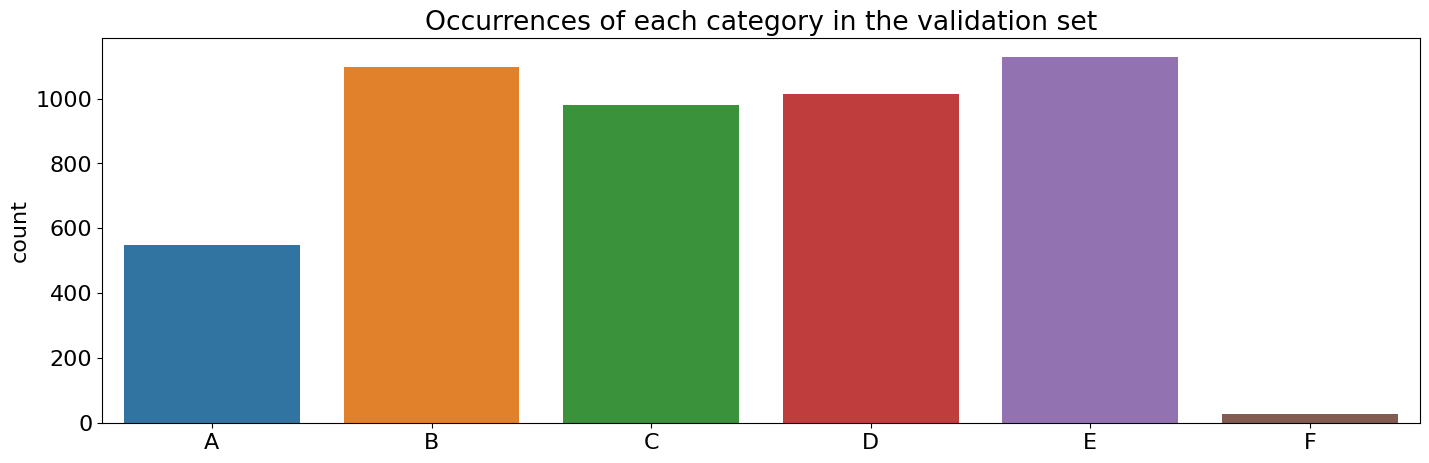

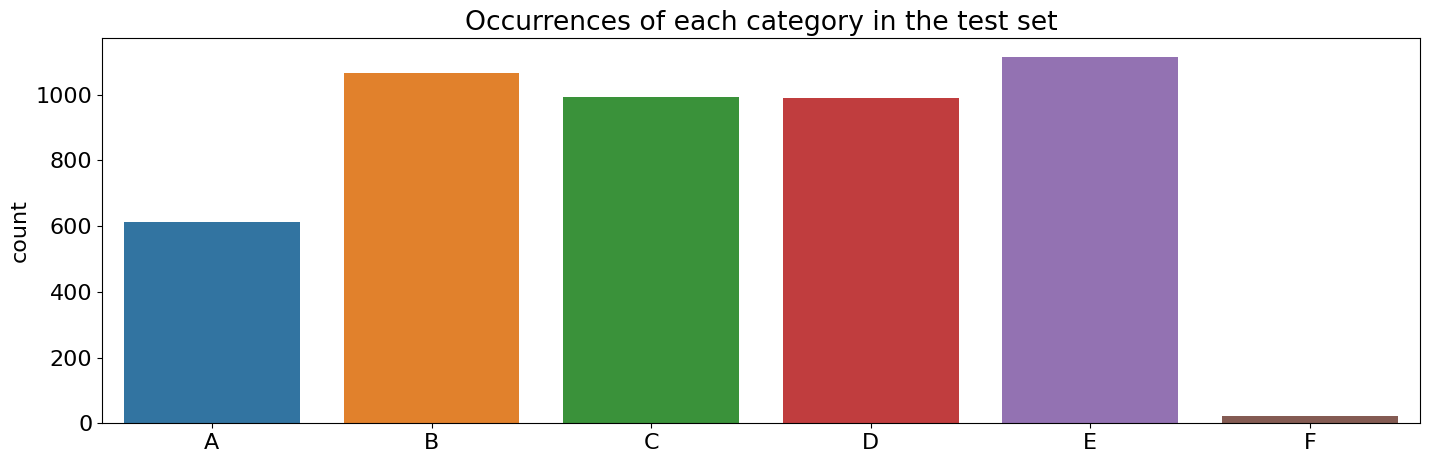

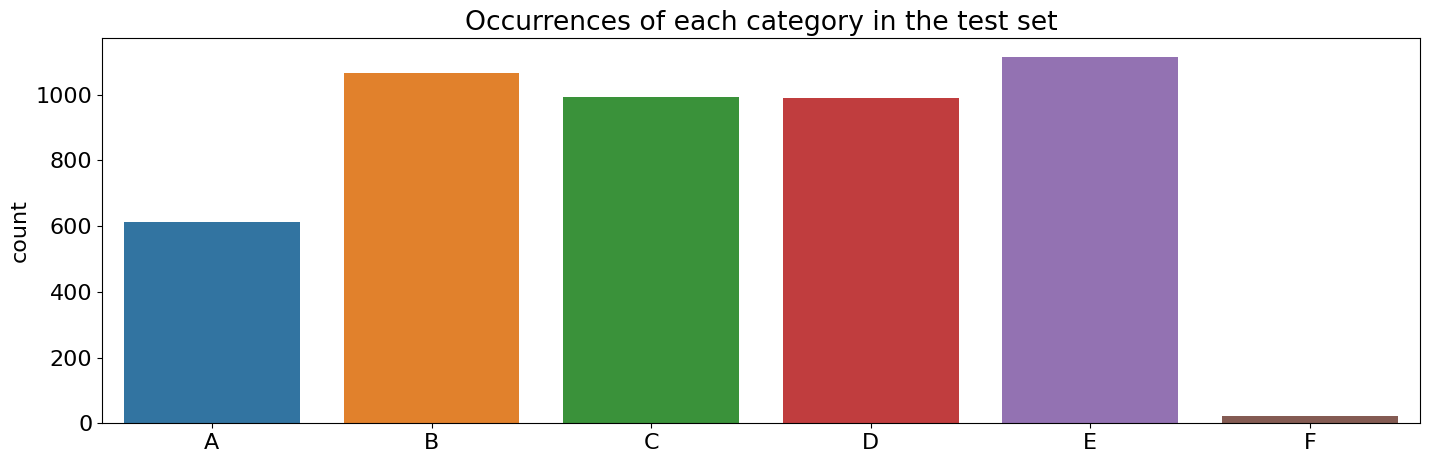

In [16]:
plot_amount_of_categories(val_categories, title='Occurrences of each category in the validation set')
plot_amount_of_categories(test_categories, title='Occurrences of each category in the test set')
plot_amount_of_categories(test_categories, title='Occurrences of each category in the test set')

In [17]:
# Map categories to integers
category_to_int = {category: i for i, category in enumerate(np.unique(categories))}
int_to_category = {i: category for category, i in category_to_int.items()}
print(category_to_int)
print(int_to_category)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}


In [18]:
# Convert categories to integers
train_categories = np.array([category_to_int[category] for category in train_categories])
val_categories = np.array([category_to_int[category] for category in val_categories])
test_categories = np.array([category_to_int[category] for category in test_categories])

In [19]:
scaler = MinMaxScaler()
scaler.fit(train_data.reshape(-1, 1))

# Normalize the data
train_data = scaler.transform(train_data.reshape(-1, 1)).reshape(train_data.shape)
val_data = scaler.transform(val_data.reshape(-1, 1)).reshape(val_data.shape)
test_data = scaler.transform(test_data.reshape(-1, 1)).reshape(test_data.shape)


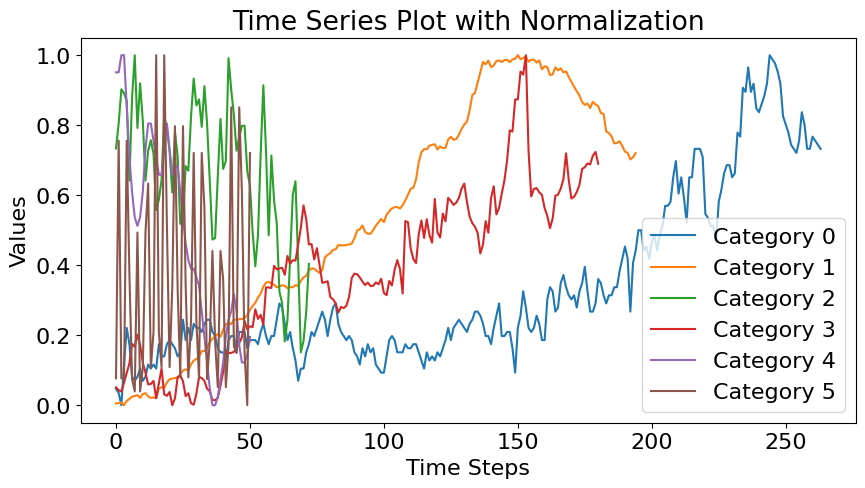

In [20]:
# Plot the first time series of each category
plt.figure(figsize=(10, 5))
for i in range(len(np.unique(categories))):
    start_index, end_index = train_valid_periods[train_categories == i][0]
    plt.plot(train_data[train_categories == i][0, start_index:end_index], label=f'Category {i}')
    
plt.title('Time Series Plot with Normalization')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

### Build and train models

In [21]:
batch_size = 128
epochs = 200

#### Vanilla Long Short Term Memory (LSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1FZ_P4SgVAA_mCZQ0tK18VwRqGqzNANOE
)

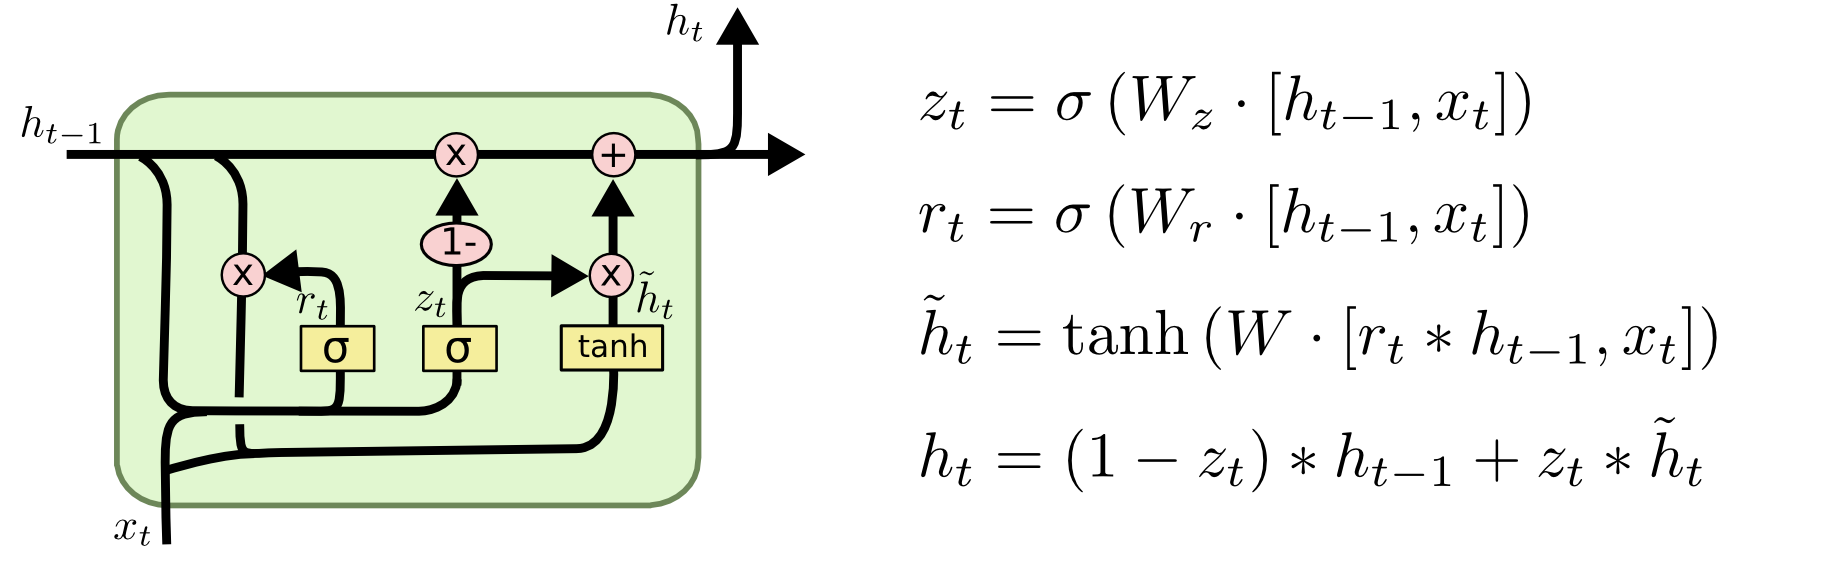

In [22]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [23]:
model = build_LSTM_classifier(input_shape=(train_data.shape[1], 1), classes=len(np.unique(categories)))

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2776, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, 2776, 128)         66560     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 215430 (841.52 KB)
Trainable params: 215430 (84

In [24]:
history = model.fit(
    x = train_data,
    y = tfk.utils.to_categorical(train_categories),
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (val_data, tfk.utils.to_categorical(val_categories)),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
  1/300 [..............................] - ETA: 9:41:39 - loss: 1.7982 - accuracy: 0.1172

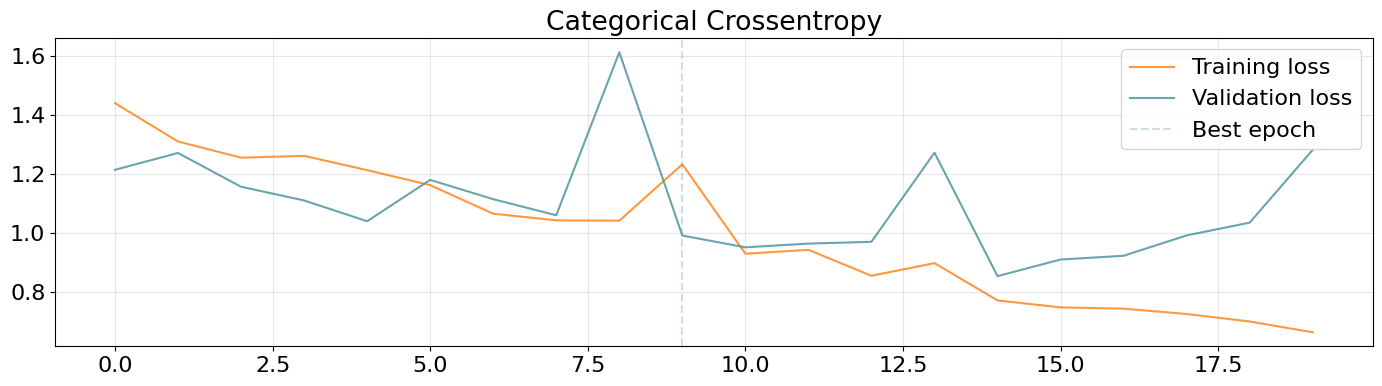

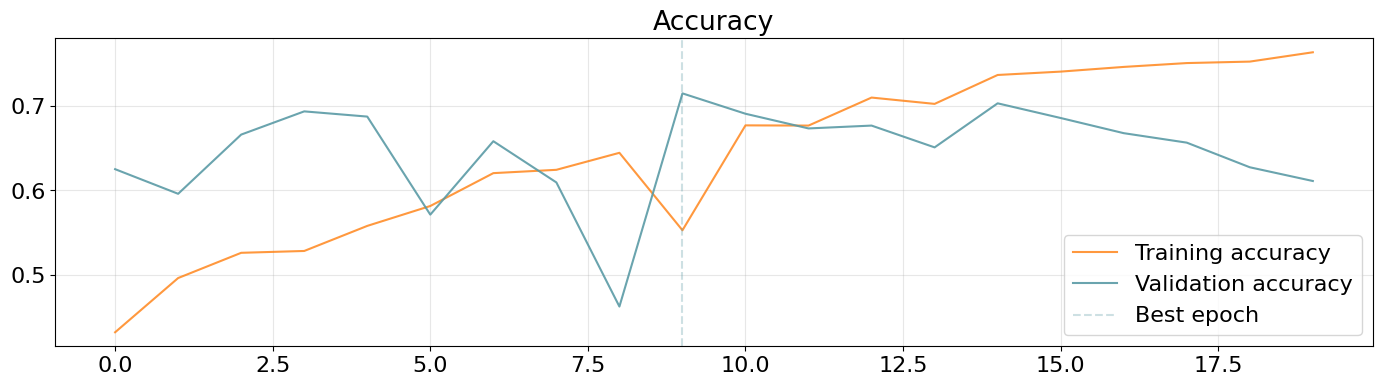

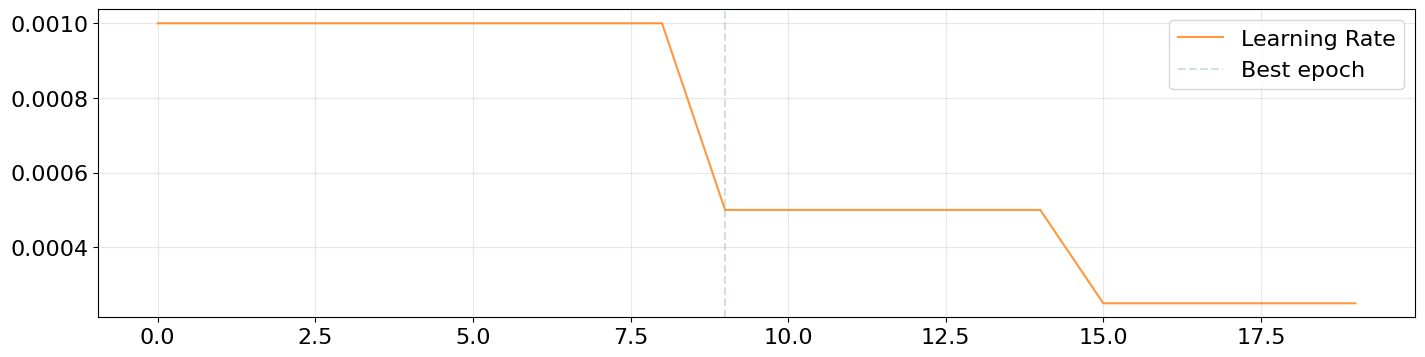

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('LSTM')
model = tfk.models.load_model('LSTM')

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_test, verbose=0)
predictions.shape

(3966, 6)

Accuracy: 0.6077
Precision: 0.4576
Recall: 0.4248
F1: 0.4008


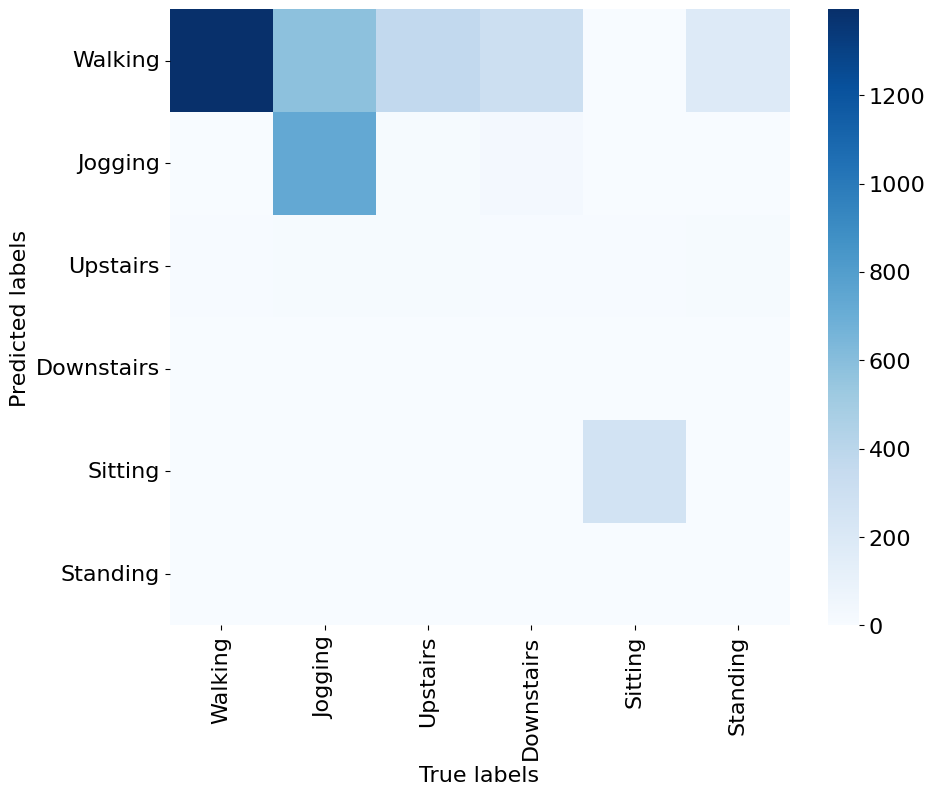

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1CN-jJqzb5AurhnMMiuvdVCaPGy2KReLc
)

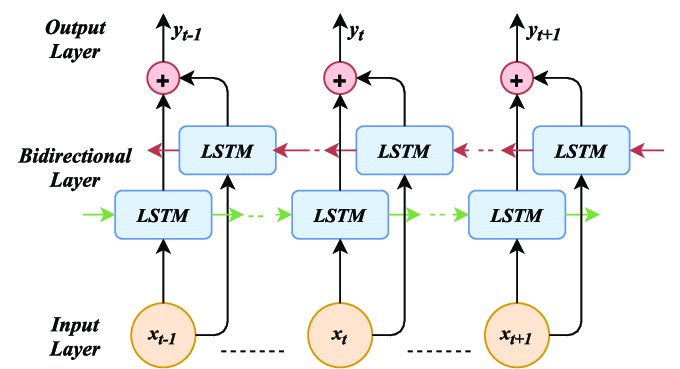

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 bidirectional (Bidirection  (None, 200, 256)          135168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774   

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
126/126 [==============================] - 22s 91ms/step - loss: 1.3645 - accuracy: 0.4717 - val_loss: 1.1832 - val_accuracy: 0.5216 - lr: 0.0010
Epoch 2/200
126/126 [==============================] - 9s 71ms/step - loss: 1.2689 - accuracy: 0.5114 - val_loss: 1.0013 - val_accuracy: 0.6644 - lr: 0.0010
Epoch 3/200
126/126 [==============================] - 8s 62ms/step - loss: 1.1948 - accuracy: 0.5499 - val_loss: 1.1175 - val_accuracy: 0.6280 - lr: 0.0010
Epoch 4/200
126/126 [==============================] - 9s 70ms/step - loss: 1.2550 - accuracy: 0.5383 - val_loss: 1.1904 - val_accuracy: 0.4695 - lr: 0.0010
Epoch 5/200
126/126 [==============================] - 8s 64ms/step - loss: 1.3462 - accuracy: 0.4875 - val_loss: 1.4579 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 6/200
126/126 [==============================] - 8s 64ms/step - loss: 1.4425 - accuracy: 0.4269 - val_loss: 1.2250 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 7/200
126/126 [==============================] - 8s

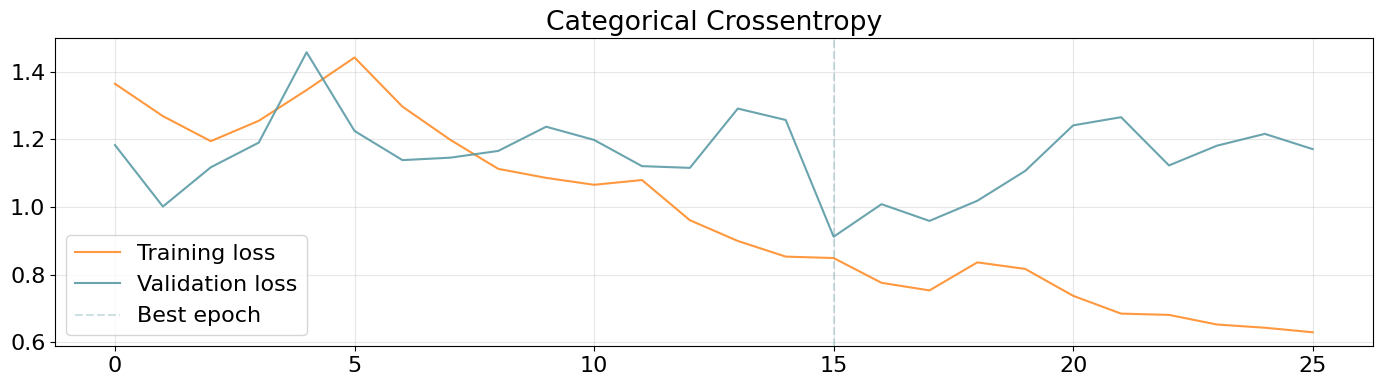

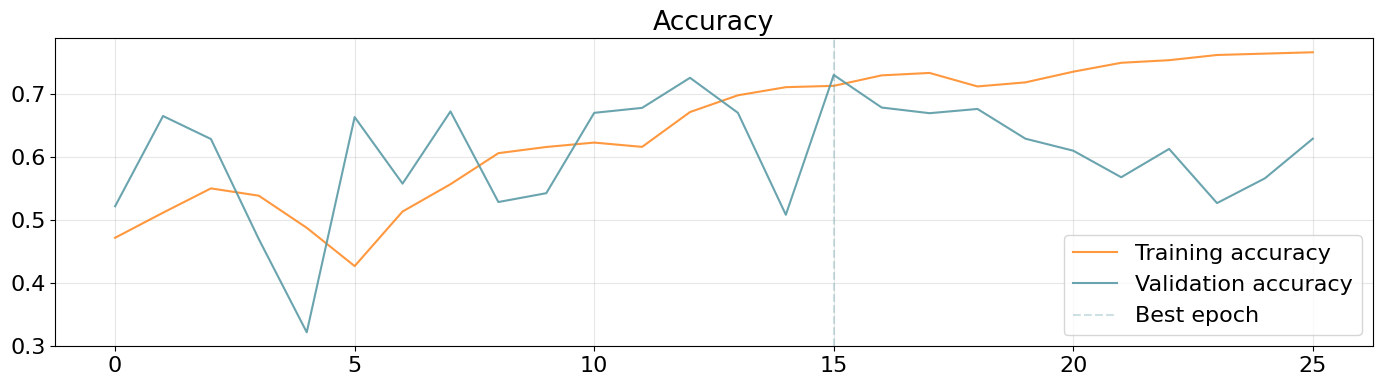

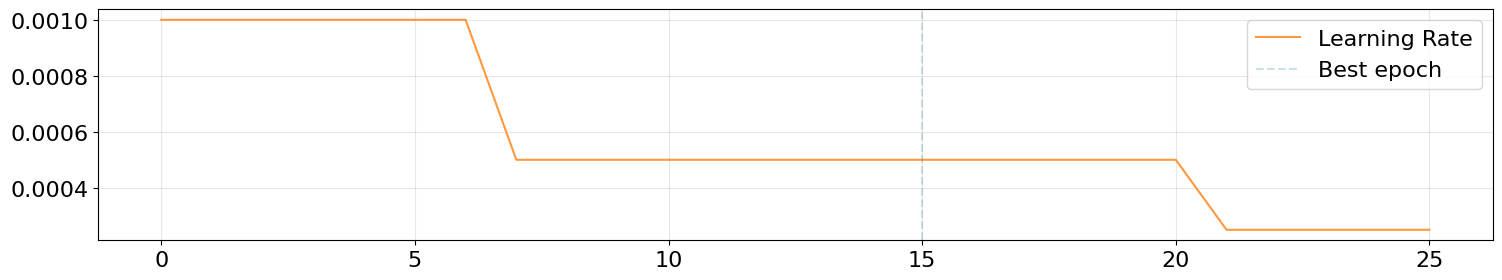

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('BiLSTM')
model = tfk.models.load_model('BiLSTM')

In [ ]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

124/124 [==============================] - 3s 13ms/step


(3966, 6)

Accuracy: 0.7063
Precision: 0.4405
Recall: 0.4638
F1: 0.4385


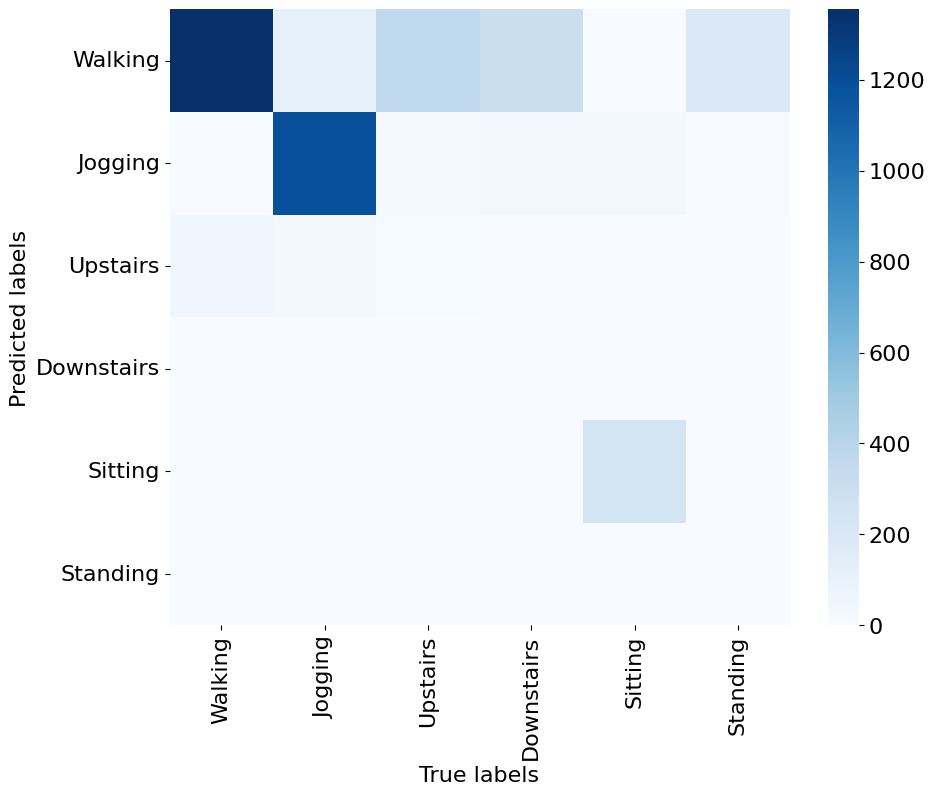

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 1D Convolutional Neural Network

![](https://drive.google.com/uc?export=view&id=10B7c-F58-eNr6CP7D_UZeVp0gTeYMrFQ
)

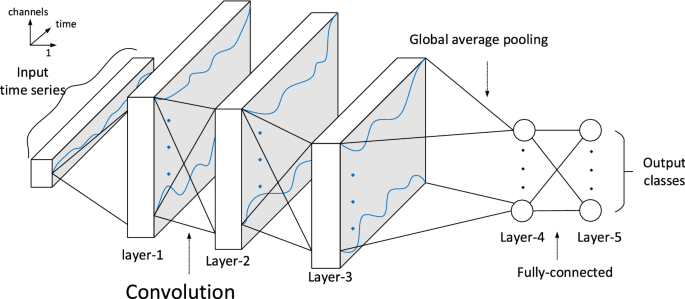

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 200, 128)          1280      
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 128)          49280     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
126/126 [==============================] - 8s 13ms/step - loss: 1.2632 - accuracy: 0.5395 - val_loss: 0.6963 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 2/200
126/126 [==============================] - 1s 9ms/step - loss: 0.7604 - accuracy: 0.7340 - val_loss: 0.5013 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 3/200
126/126 [==============================] - 1s 7ms/step - loss: 0.6272 - accuracy: 0.7703 - val_loss: 0.5152 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 4/200
126/126 [==============================] - 1s 7ms/step - loss: 0.5788 - accuracy: 0.7788 - val_loss: 0.6829 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 5/200
126/126 [==============================] - 1s 7ms/step - loss: 0.5451 - accuracy: 0.7894 - val_loss: 0.5077 - val_accuracy: 0.8174 - lr: 0.0010
Epoch 6/200
126/126 [==============================] - 1s 7ms/step - loss: 0.5266 - accuracy: 0.7933 - val_loss: 0.4824 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 7/200
126/126 [==============================] - 1s 7ms/s

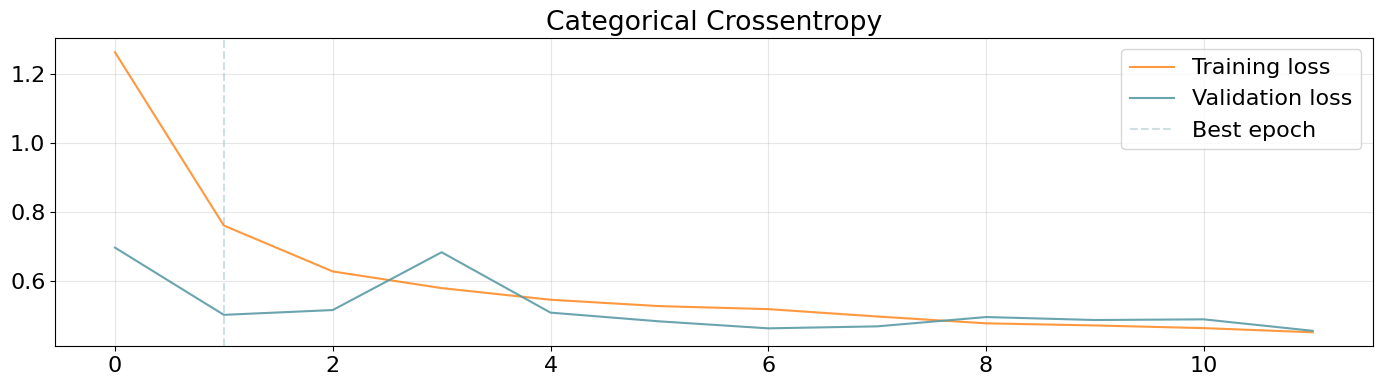

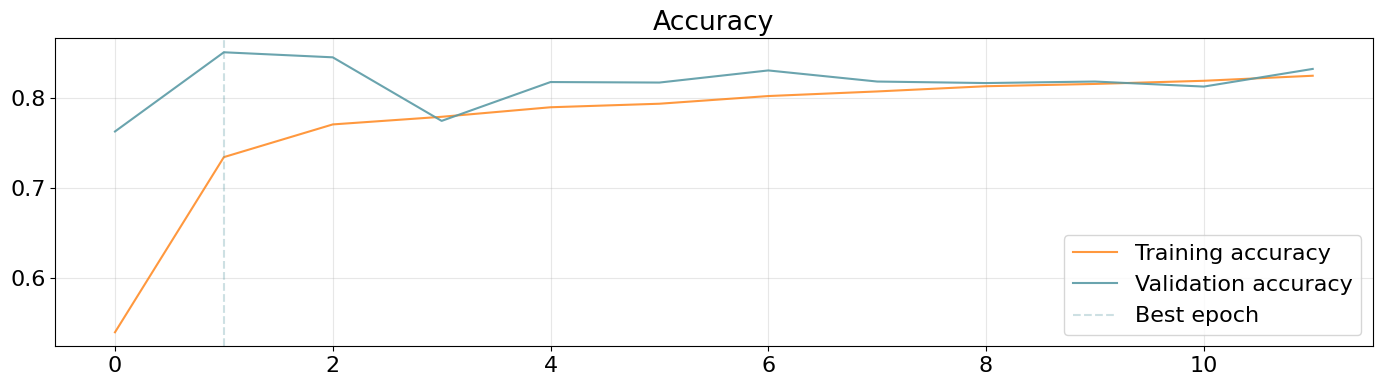

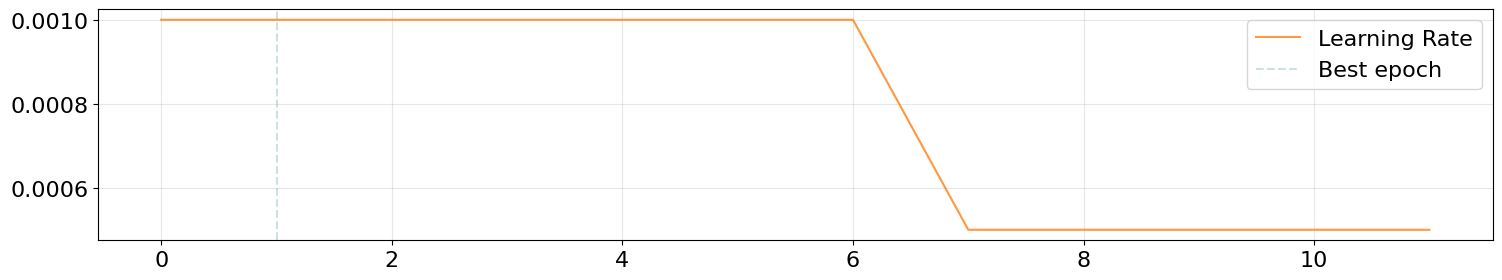

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('1DCNN')
model = tfk.models.load_model('1DCNN')

In [ ]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

124/124 [==============================] - 1s 3ms/step


(3966, 6)

Accuracy: 0.8003
Precision: 0.7076
Recall: 0.6494
F1: 0.6301


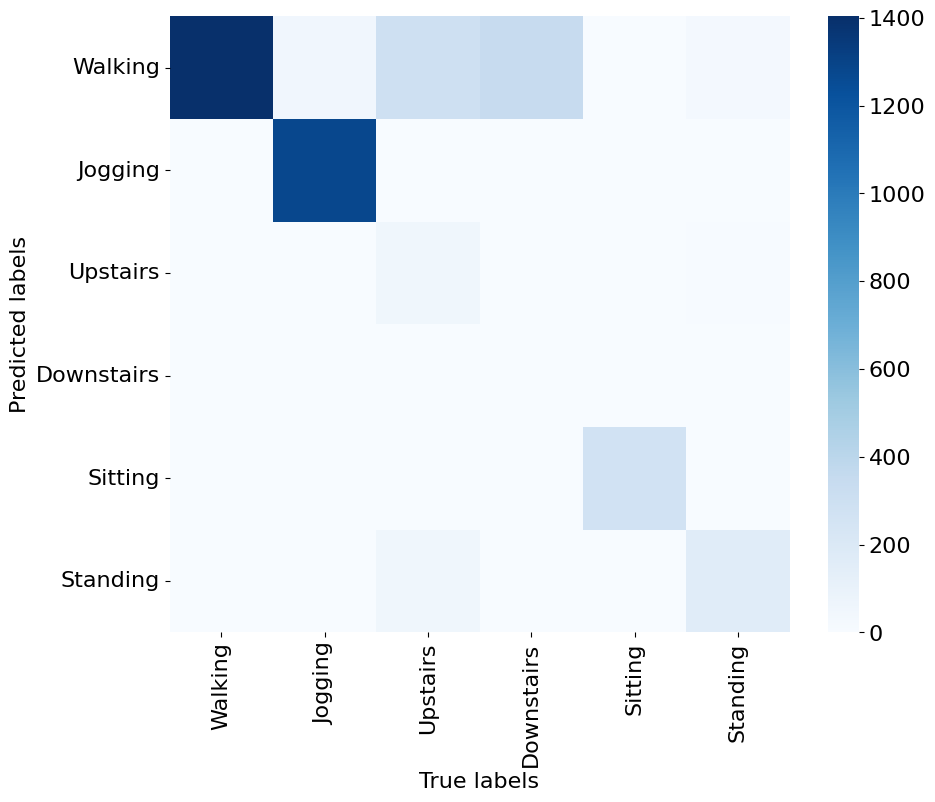

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*